In [1]:
"""
Test Script

"""
import random
import copy
import numpy as np
from vwgym import VacuumWorld, Vectorise, StepWrapper

from torch.distributions import Categorical
import matplotlib

from fun_lite_phi_return import *

random.seed(123518)

if torch.cuda.is_available():
    print('GPU Available:\t', True)
    device = 'cuda'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

else:
    device = 'cpu'

GPU Available:	 True


In [2]:
model_path = '../saved_model/trained_random_configs/vwgym_fnet_08_03_518123_ckpt.pt'

env, input_shape = make_env(grid_size=8, num_env=1, sparse=0, vectorize=True, random_seed=518123)
env = env[0]
env.state()

<class 'vacuumworld.vw.Grid'>: size: 8, agents: 1, dirts: 3, 
location(coordinate=coord(x=3, y=1), agent=agent(name='A-1', colour='white', orientation='east'), dirt=None)
location(coordinate=coord(x=6, y=4), agent=None, dirt=dirt(name='D-3', colour='green'))
location(coordinate=coord(x=7, y=4), agent=None, dirt=dirt(name='D-1', colour='orange'))
location(coordinate=coord(x=4, y=6), agent=None, dirt=dirt(name='D-2', colour='orange'))


<class 'vacuumworld.vw.Grid'>: size: 8, agents: 1, dirts: 3, 
location(coordinate=coord(x=3, y=1), agent=agent(name='A-1', colour='white', orientation='east'), dirt=None)
location(coordinate=coord(x=6, y=4), agent=None, dirt=dirt(name='D-3', colour='green'))
location(coordinate=coord(x=7, y=4), agent=None, dirt=dirt(name='D-1', colour='orange'))
location(coordinate=coord(x=4, y=6), agent=None, dirt=dirt(name='D-2', colour='orange'))

In [3]:
checkpoint = torch.load(model_path)
args = checkpoint['args']
checkpoint.keys()

dict_keys(['model', 'args', 'goal', 'man_state'])

In [4]:
num_actions = env.action_space.n
f_net = FuNet(input_shape, 256,
              10,
              0.001,
              16,
              num_actions,
              1, device)

In [5]:
f_net.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [6]:
f_net

FuNet(
  (f_percept): Percept(
    (percept): Linear(in_features=132, out_features=256, bias=True)
  )
  (manager): Manager(
    (M_space): Linear(in_features=256, out_features=256, bias=True)
    (M_goals): Linear(in_features=256, out_features=256, bias=True)
    (fc1): Linear(in_features=256, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=512, bias=True)
    (M_value): Linear(in_features=512, out_features=1, bias=True)
  )
  (worker): Worker(
    (f_stateW): Linear(in_features=256, out_features=64, bias=True)
    (phi): Linear(in_features=256, out_features=16, bias=False)
    (wfc1): Linear(in_features=64, out_features=1024, bias=True)
    (wfc2): Linear(in_features=1024, out_features=512, bias=True)
    (W_value): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [7]:
goal_history = checkpoint['goal']
s_Mt_hist = checkpoint['man_state']

In [8]:
def take_action(action_probs):
    action = action_probs.max(1)[1]
    return action.cpu().numpy()

In [9]:
with torch.no_grad():

    f_net.eval()
    predictions = []
    goal_gen = []
    goal_rec = []
    phi = []
    figures = []
    
    x = env.reset()
    env.rw_dirts = env.dirts
    print(f'Dirts Present..:{env.rw_dirts}')
        
    x = torch.from_numpy(x).float()
    x = x.view(1, -1).to(device)
    
    step = 0
    prev_action = []
    
    for __ in range(5000):
        action_probs, v_Mt, v_Wt, goal_history, s_Mt_hist, phi_g = f_net(x, goal_history, s_Mt_hist)

        goal_gen.append(goal_history[-1])
        goal_rec.append(goal_history[:args['len_hist'] + 1])
        phi.append(phi_g)

        a_t = take_action(action_probs)
        x, reward, done, ep_info = env.step(a_t[0])
        x = torch.from_numpy(x).float()
        x = x.view(1, -1).to(device)

        predictions.append(a_t[0])
        if done:
            break

Dirts Present..:3

Grid Cleaned !!

{'ep_rewards': 284, 'ep_len': 20, 'move': 12, 'clean': 4, 'turn_left': 1, 'turn_right': 3}
Episode Rewards:	 284 
 ----------------------------------------


In [10]:
import pandas as pd

p = pd.DataFrame.from_dict({'actions': predictions, 'action_meanings':[env.action_meanings[i] for i in predictions]})
p['action_meanings'].value_counts().reset_index()

,index,action_meanings
0,move,12
1,clean,4
2,turn_right,3
3,turn_left,1


In [11]:
print('Action Sequence - FuN-Lite')
print('-'*20)
for i, a in enumerate([env.action_meanings[i] for i in predictions]):
    print('-', i, a)

Action Sequence - FuN-Lite
--------------------
- 0 move
- 1 move
- 2 move
- 3 move
- 4 turn_right
- 5 move
- 6 move
- 7 move
- 8 clean
- 9 turn_right
- 10 move
- 11 clean
- 12 turn_left
- 13 move
- 14 move
- 15 turn_right
- 16 move
- 17 move
- 18 clean
- 19 clean


## Measuring Cosine Similarity of Goals

1 2 tensor([0.9900], device='cuda:0')
2 3 tensor([0.9943], device='cuda:0')
3 4 tensor([0.9965], device='cuda:0')
4 5 tensor([0.9928], device='cuda:0')
5 6 tensor([0.9891], device='cuda:0')
6 7 tensor([0.9874], device='cuda:0')
7 8 tensor([0.9900], device='cuda:0')
8 9 tensor([0.9892], device='cuda:0')
9 10 tensor([0.4520], device='cuda:0')
10 11 tensor([0.9503], device='cuda:0')
11 12 tensor([0.1619], device='cuda:0')
12 13 tensor([0.3025], device='cuda:0')
13 14 tensor([0.9794], device='cuda:0')
14 15 tensor([0.3531], device='cuda:0')
15 16 tensor([0.9682], device='cuda:0')
16 17 tensor([0.9902], device='cuda:0')
17 18 tensor([0.9727], device='cuda:0')
18 19 tensor([0.9914], device='cuda:0')
19 20 tensor([0.6169], device='cuda:0')


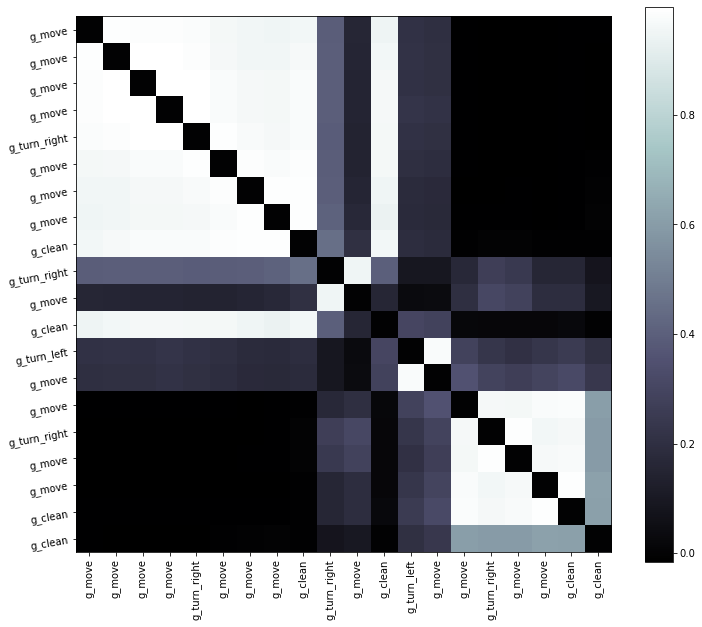

In [12]:
from torch.nn.functional import cosine_similarity as dcos
import matplotlib.pyplot as plt

for i, g in enumerate(zip(goal_gen[:-1], goal_gen[1:])):
    print(i+1, i+2, dcos(g[0], g[1]))

gm = np.zeros((len(goal_gen), len(goal_gen)))
for i, d1 in enumerate(goal_gen):
    for j, d2 in enumerate(goal_gen):
        if i == j:
            continue
        else:
            gm[i, j] = dcos(d1, d2)

am = [env.action_meanings[i] for i in predictions]

fig, ax = plt.subplots(figsize=(12, 12))

im = ax.imshow(gm, cmap='bone')

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

plt.xticks(ticks= [i for i in range(len(goal_gen))], 
           labels=[f'g_{am[i]}' for i in range(len(goal_gen))], rotation=90);
plt.yticks(ticks= [i for i in range(len(goal_gen))], 
           labels=[f'g_{am[i]}' for i in range(len(goal_gen))], rotation=10
          );
cbar = fig.colorbar(im, shrink=0.85)

In [13]:
fig.savefig('../saved_model/trained_random_configs/plots/cos_dist_518123')

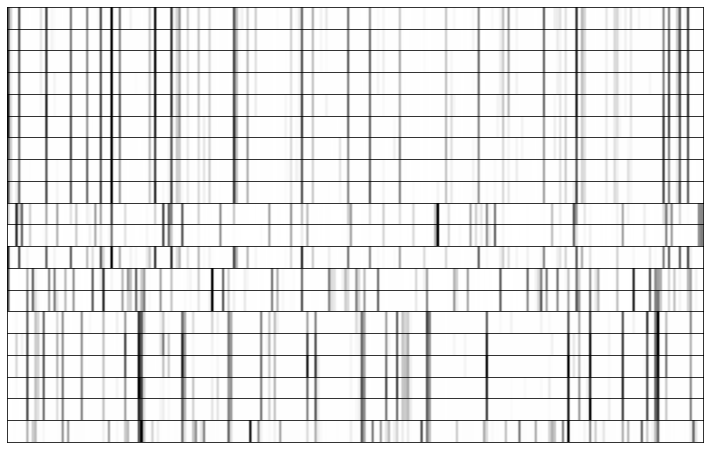

In [14]:
fig = plt.figure(figsize=(15, 8))
ax = [plt.subplot(len(goal_gen),1,i+1) for i in range(len(goal_gen))]

for g, a in enumerate(ax):
    x = goal_gen[g].detach().cpu().numpy()
    q = np.zeros((8, 256))
    for k in range(8):
        q[k, :] = x
    a.imshow(q, cmap='Greys');
    a.set_xticklabels([], visible=False)
    a.set_yticklabels([], visible=False)
    a.tick_params(axis=u'both', which=u'both',length=0)

plt.subplots_adjust(wspace=0, hspace=0.0)

In [15]:
fig.savefig('../saved_model/trained_random_configs/plots/manager_goals_518123')

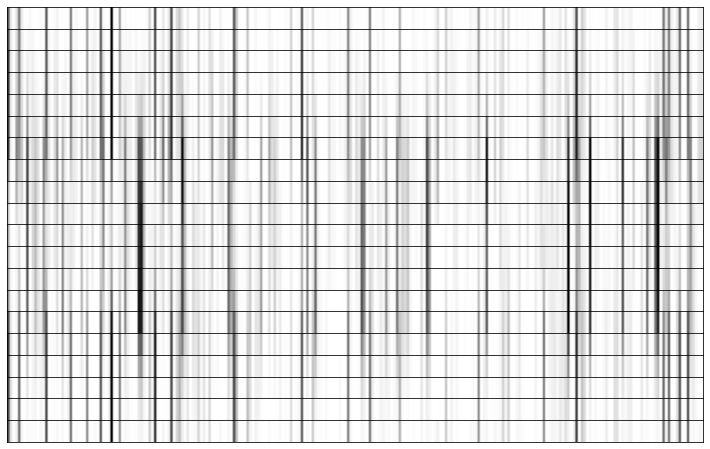

In [16]:
fig = plt.figure(figsize=(15, 8))
ax = [plt.subplot(len(goal_rec),1,i+1) for i in range(len(goal_rec))]

for g, a in enumerate(ax):
    x = [i.detach().cpu().numpy()[0] for i in goal_rec[g]]
    x = np.sum(x, axis=0).reshape(1, 256)
    q = np.zeros((8, 256))
    for k in range(8):
        q[k, :] = x
    a.imshow(q, cmap='Greys');
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(axis=u'both', which=u'both',length=0)

plt.subplots_adjust(wspace=0, hspace=0.0)

In [17]:
fig.savefig('../saved_model/trained_random_configs/plots/worker_goals_518123')

In [18]:
from sklearn.manifold import TSNE
plt.style.use('ggplot')

In [19]:
x = [g.detach().cpu().numpy()[0] for g in goal_gen]
X = np.array(x)
X_embedded = TSNE(n_components=2, perplexity=5, 
                  learning_rate=10, n_iter=100000, init='pca', random_state=518123).fit_transform(X)
for i, d in enumerate(X_embedded):
    if i % 5 == 0:
        print('-'*25)
    print(i, d)

-------------------------
0 [ 3.4690754 -6.5462246]
1 [ 3.2373855 -5.4539313]
2 [ 4.0151587 -4.4735613]
3 [ 4.1615324 -5.2122545]
4 [ 5.2281275 -4.846011 ]
-------------------------
5 [ 6.753064 -4.433868]
6 [ 8.115797  -4.2469997]
7 [ 8.827548  -3.6588852]
8 [ 7.947793  -3.3380513]
9 [6.47881   2.3109686]
-------------------------
10 [6.4491386 2.39933  ]
11 [ 3.6113749 -2.9446282]
12 [-1.2767074  2.1559763]
13 [-1.2839335  2.1895218]
14 [-1.7398009  8.358229 ]
-------------------------
15 [-0.11575025  8.319617  ]
16 [-0.29572544  9.221974  ]
17 [-1.2138772  9.166167 ]
18 [-0.9863368  7.985906 ]
19 [-2.4783034 10.00917  ]


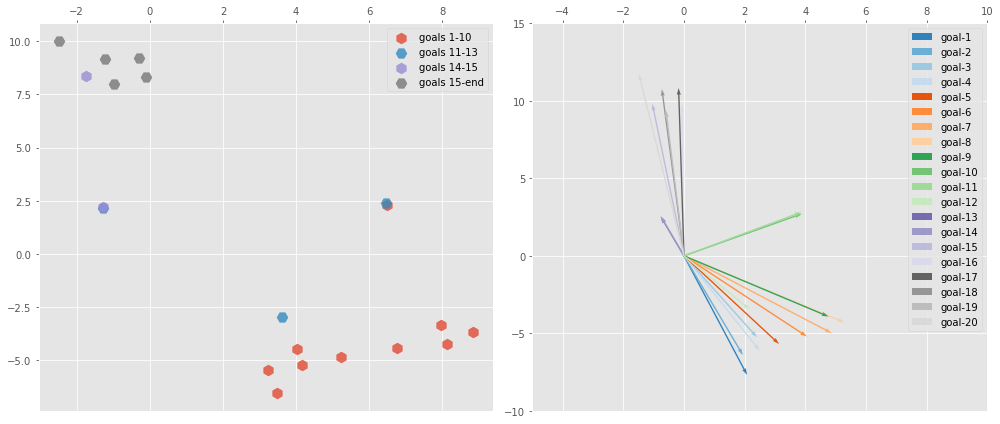

In [20]:
f = plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

norm = matplotlib.colors.Normalize()
norm.autoscale(range(len(goal_gen)))
cm = matplotlib.cm.tab20c

plt.scatter(X_embedded[:10, 0], X_embedded[:10, 1], marker="h", s=120, alpha=0.8);
plt.scatter(X_embedded[10:13, 0], X_embedded[10:13, 1], marker="H", s=120, alpha=0.8);
plt.scatter(X_embedded[13:15, 0], X_embedded[13:15, 1], marker="h", s=120, alpha=0.8);
plt.scatter(X_embedded[15:, 0], X_embedded[15:, 1], marker="H",s=120, alpha=0.8);
plt.legend(['goals 1-10', 'goals 11-13', 'goals 14-15', 'goals 15-end'])

ax = plt.subplot(1, 2, 2)
random.seed(518123)
legend = [f'goal-{i+1}' for i in range(len(goal_rec))]

for ix, i in enumerate(X_embedded):
    x_pos = [0]
    y_pos = [0]
    x_direct = i[0]
    y_direct = i[1]

    ax.quiver(x_pos,y_pos,x_direct,y_direct, color=cm(ix), scale=25, width=0.003)
    ax.axis([-5, 10, -10, 15])

    
plt.legend(legend)
plt.tight_layout()
plt.show()

In [21]:
f.savefig('../saved_model/trained_random_configs/plots/man_goals_tSNE_518123')

In [22]:
X = []
for g in range(len(goal_rec)):
    x = [i.detach().cpu().numpy()[0] for i in goal_rec[g]]
    X.append(np.sum(x, axis=0))
X = np.array(X)
X_embedded = TSNE(n_components=2, perplexity=5, 
                  learning_rate=10, n_iter=100000, init='pca', random_state=518123).fit_transform(X)
X_embedded.shape

(20, 2)

In [23]:
X_embedded

array([[  1.9381576 , -30.91604   ],
       [  6.3149567 , -26.043276  ],
       [ 11.76735   , -22.22883   ],
       [ 15.768773  , -16.331238  ],
       [ 18.794443  ,  -9.731724  ],
       [ 20.530195  ,  -2.712926  ],
       [ 20.902777  ,   4.442447  ],
       [ 19.820892  ,  11.534096  ],
       [ 17.388006  ,  18.341272  ],
       [ 12.929388  ,  24.03503   ],
       [  5.4228044 ,  25.61435   ],
       [  6.448995  ,  19.836216  ],
       [ -0.8679746 ,  19.023506  ],
       [ -5.4807596 ,  13.344223  ],
       [ -8.68862   ,   6.667572  ],
       [-10.404136  ,  -0.40332833],
       [-10.71093   ,  -7.578713  ],
       [ -9.608873  , -14.657437  ],
       [ -7.4588714 , -21.192022  ],
       [ -2.5943358 , -25.873966  ]], dtype=float32)

In [24]:
for i, d in enumerate(X_embedded):
    if i % 5 == 0:
        print('-'*25)
    print(i, d)

-------------------------
0 [  1.9381576 -30.91604  ]
1 [  6.3149567 -26.043276 ]
2 [ 11.76735 -22.22883]
3 [ 15.768773 -16.331238]
4 [18.794443 -9.731724]
-------------------------
5 [20.530195 -2.712926]
6 [20.902777  4.442447]
7 [19.820892 11.534096]
8 [17.388006 18.341272]
9 [12.929388 24.03503 ]
-------------------------
10 [ 5.4228044 25.61435  ]
11 [ 6.448995 19.836216]
12 [-0.8679746 19.023506 ]
13 [-5.4807596 13.344223 ]
14 [-8.68862   6.667572]
-------------------------
15 [-10.404136    -0.40332833]
16 [-10.71093   -7.578713]
17 [ -9.608873 -14.657437]
18 [ -7.4588714 -21.192022 ]
19 [ -2.5943358 -25.873966 ]


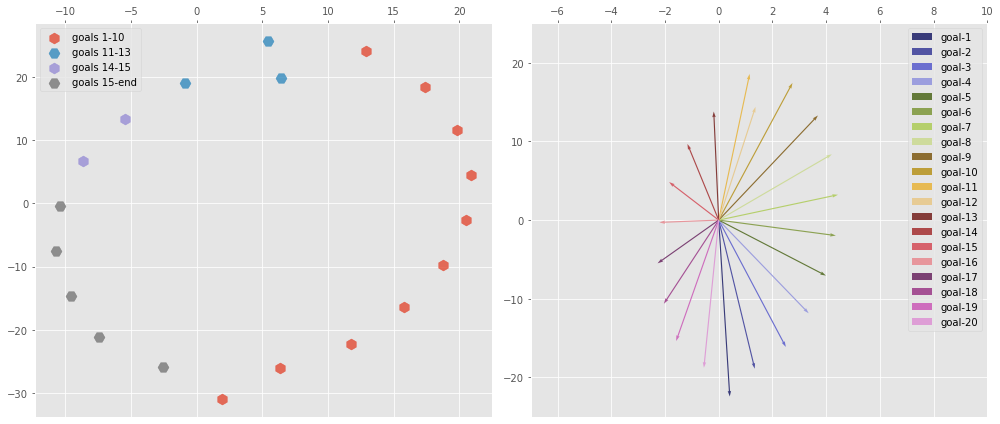

In [25]:
norm = matplotlib.colors.Normalize()
norm.autoscale(range(len(goal_gen)))
cm = matplotlib.cm.tab20b

f = plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
colours = np.linspace(0.1, 0.95, num=21)
plt.scatter(X_embedded[:10, 0], X_embedded[:10, 1], marker="h", s=120, alpha=0.8);
plt.scatter(X_embedded[10:13, 0], X_embedded[10:13, 1], marker="H", s=120, alpha=0.8);
plt.scatter(X_embedded[13:15, 0], X_embedded[13:15, 1], marker="h", s=120, alpha=0.8);
plt.scatter(X_embedded[15:, 0], X_embedded[15:, 1], marker="H",s=120, alpha=0.8);
plt.legend(['goals 1-10', 'goals 11-13', 'goals 14-15', 'goals 15-end'])



ax = plt.subplot(1, 2, 2)
random.seed(518123)
legend = [f'goal-{i+1}' for i in range(len(goal_rec))]

for ix, i in enumerate(X_embedded):
    x_pos = [0]
    y_pos = [0]
    x_direct = i[0]
    y_direct = i[1]

    ax.quiver(x_pos,y_pos,x_direct,y_direct, color=cm(ix), scale=80, width=0.0025)
    ax.axis([-7, 10, -25, 25])
    
plt.legend(legend)
plt.tight_layout()
plt.show()

In [26]:
f.savefig('../saved_model/trained_random_configs/plots/worker_goals_tSNE_518123')

In [27]:
x = [g.detach().cpu().numpy()[0] for g in phi]
X = np.array(x)
X_embedded = TSNE(n_components=2, perplexity=5, 
                  learning_rate=10, n_iter=100000, init='pca', random_state=518123).fit_transform(X)
for i, d in enumerate(X_embedded):
    if i % 5 == 0:
        print('-'*25)
    print(i, d)

-------------------------
0 [56.725533 17.284147]
1 [43.890827 23.433773]
2 [31.012436 31.502193]
3 [17.449675 35.430103]
4 [ 2.9437728 35.87251  ]
-------------------------
5 [-11.309749  32.630764]
6 [-25.107857  26.167856]
7 [-37.03393   18.293346]
8 [-49.1278   11.09436]
9 [-51.235146   -1.5224682]
-------------------------
10 [-43.84223 -20.31429]
11 [-34.24794  -14.237758]
12 [-24.43877 -26.82444]
13 [ -9.305629 -32.750576]
14 [  4.8608465 -33.993023 ]
-------------------------
15 [ 18.821747 -31.476986]
16 [ 32.53912  -25.350193]
17 [ 44.167633 -16.52297 ]
18 [56.358982 -9.279316]
19 [54.153404   3.5531015]


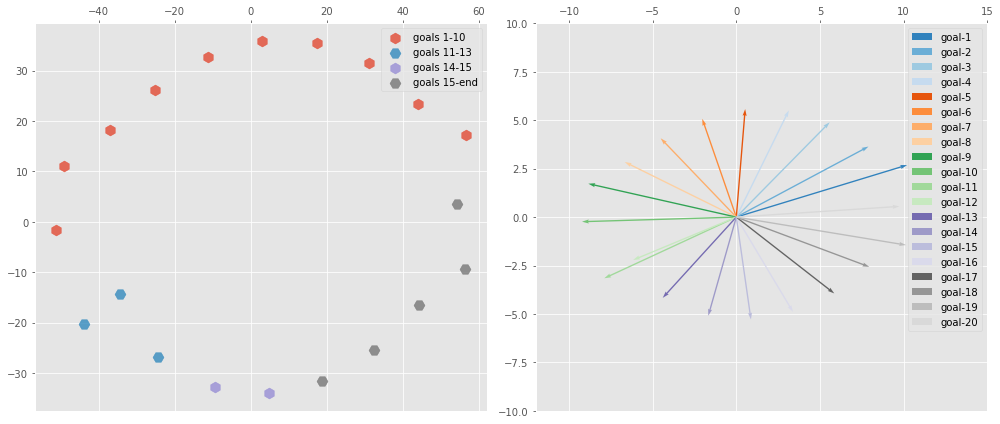

In [28]:
f = plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

norm = matplotlib.colors.Normalize()
norm.autoscale(range(len(phi)))
cm = matplotlib.cm.tab20c

plt.scatter(X_embedded[:10, 0], X_embedded[:10, 1], marker="h", s=120, alpha=0.8);
plt.scatter(X_embedded[10:13, 0], X_embedded[10:13, 1], marker="H", s=120, alpha=0.8);
plt.scatter(X_embedded[13:15, 0], X_embedded[13:15, 1], marker="h", s=120, alpha=0.8);
plt.scatter(X_embedded[15:, 0], X_embedded[15:, 1], marker="H",s=120, alpha=0.8);
plt.legend(['goals 1-10', 'goals 11-13', 'goals 14-15', 'goals 15-end'])

ax = plt.subplot(1, 2, 2)
random.seed(518123)
legend = [f'goal-{i+1}' for i in range(len(phi))]

for ix, i in enumerate(X_embedded):
    x_pos = [0]
    y_pos = [0]
    x_direct = i[0]
    y_direct = i[1]

    ax.quiver(x_pos,y_pos,x_direct,y_direct, color=cm(ix), scale=150, width=0.003)
    ax.axis([-12, 15, -10, 10])

    
plt.legend(legend)
plt.tight_layout()
plt.show()

In [29]:
f.savefig('../saved_model/trained_random_configs/plots/worker_phi_goals_tSNE_518123')